In [28]:
import re
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import ConnectionPatch, FancyBboxPatch
import textwrap

# --- Helper Functions ---
def deepen_hex_color(hex_str, amount=0.85):
    if not hex_str: return '#000000' 
    try:
        if hex_str.startswith('#'):
            hex_str = hex_str[1:]
        rgb = tuple(int(hex_str[i:i+2], 16) for i in (0, 2, 4))
        deepened_rgb = tuple(min(255, max(0, int(c * amount))) for c in rgb)
        return mcolors.rgb2hex(tuple(c/255.0 for c in deepened_rgb))
    except ValueError:
        return '#000000'

def visualize_mermaid_hierarchy(mermaid_code: str, book_title: str):
    G = nx.DiGraph()
    node_labels = {}
    
    # --- 3. Add Book Title as a new root node ---
    BOOK_ROOT_NODE_ID = "BOOK_ROOT"
    G.add_node(BOOK_ROOT_NODE_ID)
    node_labels[BOOK_ROOT_NODE_ID] = book_title
    
    node_pattern = re.compile(r'(\w+)\["(.+?)"\]')
    edge_pattern = re.compile(r'(\w+)\s*-->\s*(\w+)')

    # Parse original nodes and labels
    for match in node_pattern.finditer(mermaid_code):
        node_id, label = match.groups()
        label = label.strip().lstrip("- ").lstrip("* ")
        node_labels[node_id] = label
        if not G.has_node(node_id):
            G.add_node(node_id)

    # Parse original edges
    # -------------------------------------------------------------
    # When an edge is declared in Mermaid like:
    #     A["Some label"] --> B["Another label"];
    # naive regexes that look directly for "A --> B" will fail because
    # the text between the node-ID (A) and the arrow ("-->") contains a
    # label definition in square brackets.  To avoid accidentally
    # capturing the last word of the label as the parent ID, we first
    # strip out every  ["…"]  label segment.  This leaves us with plain
    #   A --> B
    # lines that the simple edge pattern can parse reliably.
    # -------------------------------------------------------------
    code_without_labels = re.sub(r'\[".*?"\]', '', mermaid_code)

    for match in edge_pattern.finditer(code_without_labels):
        parent_id, child_id = match.groups()
        if not G.has_node(parent_id):
            G.add_node(parent_id)
        if not G.has_node(child_id):
            G.add_node(child_id)
        G.add_edge(parent_id, child_id)

    # Debug: Check if node E exists in the graph
    print(f"Node E exists in graph: {'E' in G.nodes()}")
    print(f"Node E has edges: {list(G.in_edges('E')) if 'E' in G.nodes() else 'N/A'}")
    print(f"Node E children: {list(G.out_edges('E')) if 'E' in G.nodes() else 'N/A'}")

    # Identify original root nodes (A, D, H) and make them children of BOOK_ROOT_NODE_ID
    original_potential_root_ids = ['A', 'D', 'H'] 
    original_roots_found = []
    for r_id in original_potential_root_ids:
        if r_id in G and G.in_degree(r_id) == 0 : # Check if it's truly a root in the original structure
            original_roots_found.append(r_id)
            G.add_edge(BOOK_ROOT_NODE_ID, r_id)
    
    # If A, D, H weren't actual roots (e.g. part of a larger parsed graph unexpectedly)
    # this fallback is less likely needed now with explicit book root.
    if not original_roots_found: # Fallback if specific IDs not found as roots
        temp_original_roots = [n for n in G.nodes() if G.in_degree(n) == 0 and n != BOOK_ROOT_NODE_ID]
        for r_id in temp_original_roots:
            G.add_edge(BOOK_ROOT_NODE_ID, r_id)
            original_roots_found.append(r_id)

    # -------------------------------------------------------------
    # EXTRA SAFETY: After the steps above, there may still be "orphan"
    # roots that were not in the hard-coded list (e.g. B, C, E, F, G).
    # Connect **any** remaining zero-in-degree nodes to BOOK_ROOT so the
    # layout routine will visit them and assign positions.
    # -------------------------------------------------------------
    remaining_orphan_roots = [n for n in G.nodes() if n != BOOK_ROOT_NODE_ID and G.in_degree(n) == 0]
    for orphan_id in remaining_orphan_roots:
        if not G.has_edge(BOOK_ROOT_NODE_ID, orphan_id):
            G.add_edge(BOOK_ROOT_NODE_ID, orphan_id)

    # --- Node Depths and Colors ---
    node_depths = {}
    node_colors = {}
    # Color for the new book root
    book_root_color = '#6c757d' # A neutral gray
    
    # Base colors for the main sections (children of book root)
    section_base_colors_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

    # The actual root of the entire graph is now BOOK_ROOT_NODE_ID
    graph_root_nodes = [BOOK_ROOT_NODE_ID] 

    for root_id in graph_root_nodes: # Should only be BOOK_ROOT_NODE_ID
        node_depths[root_id] = 0
        node_colors[root_id] = book_root_color
        
        queue = [(root_id, 0)]  # (node_id, depth)
        head = 0
        
        visited_bfs_color_depth = {root_id}

        while head < len(queue):
            curr_node_id, depth = queue[head]
            head += 1
            
            current_parent_color = node_colors[curr_node_id]
            successors = sorted(list(G.successors(curr_node_id)))
            
            for i, child_id in enumerate(successors):
                if child_id not in visited_bfs_color_depth:
                    visited_bfs_color_depth.add(child_id)
                    new_depth = depth + 1
                    node_depths[child_id] = new_depth
                    
                    if curr_node_id == BOOK_ROOT_NODE_ID: # Children of book root get base section colors
                        node_colors[child_id] = section_base_colors_list[i % len(section_base_colors_list)]
                    else: # Deeper nodes inherit and deepen
                        node_colors[child_id] = deepen_hex_color(current_parent_color)
                    
                    queue.append((child_id, new_depth))
                # In case a node is visited again via a different path (not in tree), update if shorter depth
                elif node_depths.get(child_id, float('inf')) > depth + 1:
                     node_depths[child_id] = depth + 1
                     # Recolor if path is shorter - depends on desired logic for non-trees
                     if curr_node_id == BOOK_ROOT_NODE_ID:
                         node_colors[child_id] = section_base_colors_list[i % len(section_base_colors_list)]
                     else:
                         node_colors[child_id] = deepen_hex_color(current_parent_color)
                     # No need to re-add to queue if already processed at a greater or equal depth

    # --- Node Positions (Layout) ---
    node_positions = {}
    # Adjusted spacing parameters for request 1 (less padding/overlap)
    horizontal_spacing = 2.8       # Reduced
    vertical_slot_height = 1.0     # Height allocated for a single node's layout slot
    vertical_tree_spacing = 1.5    # Reduced (gap between main branches from book root)
    
    current_tree_base_y = 0.0

    max_overall_depth = 0
    if node_depths:
         max_overall_depth = max(node_depths.values() or [0])
    
    memoized_layout_extents = {} 

    # Debug: Print all nodes in the graph for verification
    print(f"All nodes in graph: {sorted(list(G.nodes()))}")

    # Start layout from the actual single root: BOOK_ROOT_NODE_ID
    for processing_root_id in graph_root_nodes: 
        # This recursive function lays out a tree.
        # y_slot_start is the Y coordinate where the current node's allocated slot begins.
        # It returns the Y coordinate where the next SIBLING's slot should begin.
        def layout_subtree(node_id, y_slot_start):
            if node_id in memoized_layout_extents: # Primarily for non-tree graphs; less effect here
                # This logic assumes if a node is re-visited, its subtree bottom is what we need
                return memoized_layout_extents[node_id]['y_max_extent']

            children = sorted(list(G.successors(node_id)))
            node_x = node_depths.get(node_id, 0) * horizontal_spacing
            
            # If it's a leaf node:
            if not children:
                node_y_center = y_slot_start + vertical_slot_height / 2.0
                node_positions[node_id] = (node_x, node_y_center)
                
                memoized_layout_extents[node_id] = {
                    'y_center': node_y_center, 
                    'y_min_extent': y_slot_start, # Top of its slot
                    'y_max_extent': y_slot_start + vertical_slot_height # Bottom of its slot
                }
                return y_slot_start + vertical_slot_height # Next sibling's slot starts after this one

            # If it's a parent node (has children):
            child_centers_y = [] 
            child_min_extents = []
            child_max_extents = []
            
            # child_y_current_slot_start is the Y where the *next* child's slot begins.
            child_y_current_slot_start = y_slot_start 

            for child in children:
                y_after_child_subtree = layout_subtree(child, child_y_current_slot_start)
                
                if child in node_positions and child in memoized_layout_extents:
                    child_centers_y.append(node_positions[child][1]) 
                    child_min_extents.append(memoized_layout_extents[child]['y_min_extent'])
                    child_max_extents.append(memoized_layout_extents[child]['y_max_extent'])
                
                child_y_current_slot_start = y_after_child_subtree # Next child's slot starts where previous ended
            
            parent_y_center = 0
            if child_centers_y: 
                parent_y_center = sum(child_centers_y) / len(child_centers_y)
            else: 
                # If it has children but none were positioned (error or empty G.successors list initially)
                # Place parent at the start of its allocated conceptual slot (though it's not a leaf)
                parent_y_center = y_slot_start + vertical_slot_height / 2.0
            
            node_positions[node_id] = (node_x, parent_y_center)
            
            # Determine the overall vertical extent of this parent's subtree
            # If it has children, its extent is defined by its children's extents.
            # If no children were effectively laid out, its extent is like a single slot.
            overall_min_extent = min(child_min_extents) if child_min_extents else (parent_y_center - vertical_slot_height / 2.0)
            overall_max_extent = max(child_max_extents) if child_max_extents else (parent_y_center + vertical_slot_height / 2.0)
            
            memoized_layout_extents[node_id] = {
                'y_center': parent_y_center, 
                'y_min_extent': overall_min_extent,
                'y_max_extent': overall_max_extent
            }
            return overall_max_extent

        # Initiate layout for the current root's tree
        # (BOOK_ROOT_NODE_ID, and its children A,D,H which are roots of subtrees)
        # The y_slot_start for the absolute root can be 0.
        # Its children will be handled by the recursion.
        tree_y_max_extent = layout_subtree(processing_root_id, current_tree_base_y)
        # current_tree_base_y should not need updating if there's only one absolute root.
        # If multiple disconnected components were drawn, this would space them.
        current_tree_base_y = tree_y_max_extent + vertical_tree_spacing


    if node_positions:
        all_y_coords = [pos[1] for pos in node_positions.values() if pos is not None]
        if all_y_coords:
            min_y_val = min(all_y_coords)
            y_shift = abs(min_y_val) + 0.5 
            
            shifted_node_positions = {}
            for node_id_to_shift, pos_val in node_positions.items():
                if pos_val:
                    x, y = pos_val
                    shifted_node_positions[node_id_to_shift] = (x, y + y_shift)
            node_positions = shifted_node_positions
            current_tree_base_y += y_shift

    # Debug: Check if node E has a position
    print(f"Node E has position: {node_positions.get('E')}")
    
    # Debug: Print nodes that have no positions
    missing_positions = [n for n in G.nodes() if n not in node_positions or node_positions[n] is None]
    print(f"Nodes without positions: {missing_positions}")

    # --- Drawing ---
    max_x_pos = (max_overall_depth + 1) * horizontal_spacing
    max_y_pos = max(10, current_tree_base_y) 

    fig, ax = plt.subplots(figsize=(max(16, max_x_pos / 1.5), max(13, max_y_pos / 1.3 )))
    ax.set_xlim(-1.0, max_x_pos + 1.0) # Adjusted padding
    ax.set_ylim(-1.0, max_y_pos + 1.0) # Adjusted padding
    ax.axis('off')

    # Make sure all nodes in the graph have positions before drawing
    for node_id in G.nodes():
        if node_id not in node_positions or node_positions[node_id] is None:
            # Calculate a position based on parent and apply
            parents = list(G.predecessors(node_id))
            if parents:
                parent_id = parents[0]
                if parent_id in node_positions and node_positions[parent_id] is not None:
                    parent_x, parent_y = node_positions[parent_id]
                    # Position missing node at depth + 1, slightly offset
                    node_depths[node_id] = node_depths.get(parent_id, 0) + 1
                    node_x = node_depths[node_id] * horizontal_spacing
                    # Add a small random offset to y to avoid overlaps
                    import random
                    node_y = parent_y + random.uniform(-0.5, 0.5)
                    node_positions[node_id] = (node_x, node_y)
                    print(f"Fixed position for node {node_id}: {node_positions[node_id]}")
                    # Assign color based on parent
                    node_colors[node_id] = deepen_hex_color(node_colors.get(parent_id, '#CCCCCC'))

    for u, v in G.edges():
        if u not in node_positions or v not in node_positions or node_positions[u] is None or node_positions[v] is None: continue
        pos_u = node_positions[u]
        pos_v = node_positions[v]
        edge_color = node_colors.get(v, 'gray') 
        cp = ConnectionPatch(xyA=pos_v, xyB=pos_u, 
                             coordsA='data', coordsB='data',
                             axesA=ax, axesB=ax,
                             arrowstyle="-", 
                             connectionstyle="arc3,rad=0.15", # Slightly less curve
                             color=edge_color, linewidth=1.0, # Thinner line
                             shrinkA=8, shrinkB=8) # Increased shrink for more gap
        ax.add_patch(cp)

    # Adjusted text and box parameters for request 1
    avg_char_width_approx = 0.05 
    char_height_approx = 0.125 
    min_box_width = 1.2 
    max_box_width_for_wrap = horizontal_spacing * 0.9 # Allow box to use more horiz space
    text_padding = 0.05 # Reduced

    for node_id in G.nodes():
        if node_id not in node_positions or node_positions[node_id] is None: continue
        pos = node_positions[node_id]
        label = node_labels.get(node_id, node_id)
        # Ensure wrap_chars is at least e.g. 15-20 to avoid excessive narrow wrapping.
        wrap_chars = max(30, int(max_box_width_for_wrap / avg_char_width_approx))
        wrapped_label = '\n'.join(textwrap.wrap(label, width=wrap_chars, 
                                                break_long_words=True,
                                                fix_sentence_endings=True))
        num_lines = wrapped_label.count('\n') + 1
        longest_line_len = 0
        if wrapped_label:
             longest_line_len = max(len(s) for s in wrapped_label.split('\n'))
        
        box_width = max(min_box_width, longest_line_len * avg_char_width_approx + 2 * text_padding)
        box_width = min(box_width, max_box_width_for_wrap + text_padding*0.5) # Cap based on available space
        
        # Box height must accommodate text.
        # The layout uses vertical_slot_height conceptually. We try to fit box in it.
        estimated_text_block_height = num_lines * char_height_approx + (num_lines -1) * 0.04 # char_height + interline_spacing
        box_height = estimated_text_block_height + 2 * text_padding
        
        node_color = node_colors.get(node_id, '#CCCCCC') 
        bbox_patch = FancyBboxPatch((pos[0] - box_width / 2, pos[1] - box_height / 2),
                                     box_width, box_height,
                                     boxstyle=f"round,pad={text_padding},rounding_size=0.08", 
                                     ec=node_color, fc='white', lw=1.2) # Thinner border
        ax.add_patch(bbox_patch)
        ax.text(pos[0], pos[1], wrapped_label,
                ha='center', va='center', fontsize=6, color='black', # Further reduced font
                linespacing=1.15) # Reduced linespacing

    plt.title(book_title, fontsize=16) # Generic title for now
    plt.gca().invert_yaxis() 
    plt.tight_layout() # Apply tight_layout before saving

    # Save the figure with higher resolution before showing
    output_filename = f"book-{book_title}.png"
    plt.savefig(output_filename, dpi=200, bbox_inches='tight')
    print(f"High-resolution image saved as {output_filename}")

    plt.show()
    
    # Diagnostic print:
    print("--- Node Position Diagnostics ---")
    for n_id in sorted(G.nodes()):
        if n_id not in node_positions or node_positions[n_id] is None:
            print(f"MISSING POSITION: {n_id} ('{node_labels.get(n_id)}')")
        else:
            print(f"Positioned: {n_id} ('{node_labels.get(n_id, '')[:30]}...') at {node_positions[n_id]}")


Node E exists in graph: True
Node E has edges: []
Node E children: [('E', 'E1'), ('E', 'E2')]
All nodes in graph: ['A', 'A1', 'A1a', 'A1b', 'A2', 'A2a', 'A2b', 'B', 'B1', 'B1a', 'B1b', 'B1c', 'B2', 'B2a', 'B2b', 'BOOK_ROOT', 'C', 'C1', 'C1a', 'C1b', 'C2', 'C2a', 'C2b', 'D', 'D1', 'D1a', 'D1b', 'D1c', 'D2', 'D2a', 'D2b', 'E', 'E1', 'E1a', 'E1b', 'E1c', 'E2', 'E2a', 'E2b', 'F', 'F1', 'F1a', 'F1b', 'F1c', 'F2', 'F2a', 'F2b', 'G', 'G1', 'G1a', 'G1b', 'G1c', 'G2', 'G2a', 'G2b', 'H', 'H1', 'H1a', 'H1b', 'H1c', 'H2', 'H2a', 'H2b', 'I', 'I1', 'I1a', 'I1b', 'I1c', 'I2', 'I2a', 'I2b']
Node E has position: (2.8, 21.75)
Nodes without positions: []
High-resolution image saved as book-Algorithms to Live By: The Computer Science of Human Decisions.png


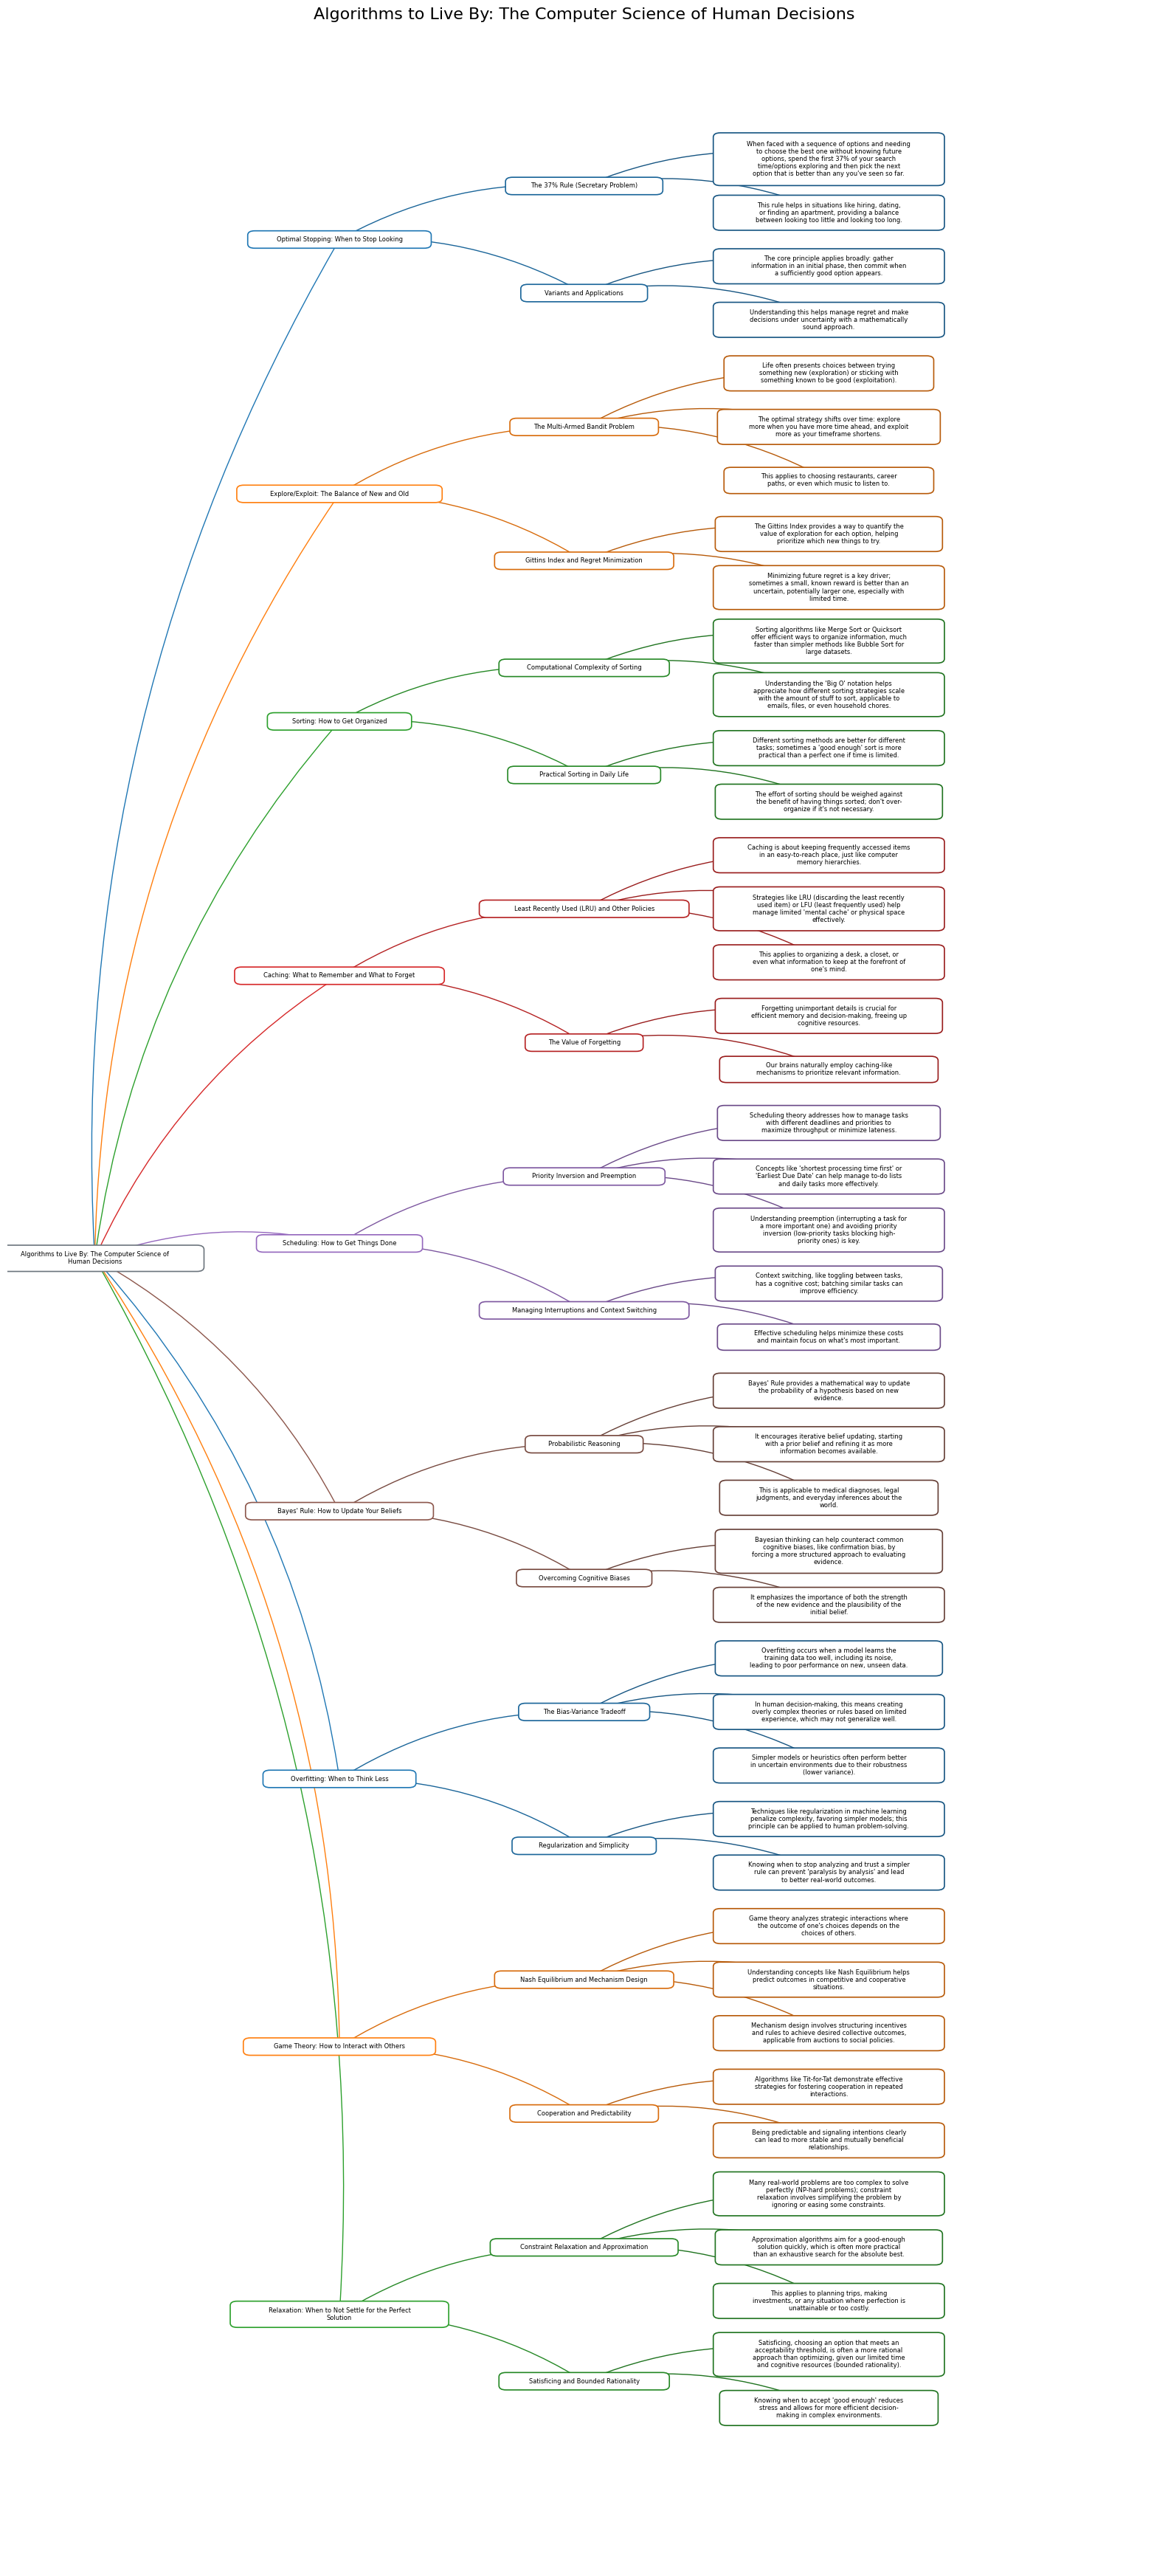

--- Node Position Diagnostics ---
Positioned: A ('Optimal Stopping: When to Stop...') at (2.8, 3.0)
Positioned: A1 ('The 37% Rule (Secretary Proble...') at (5.6, 2.0)
Positioned: A1a ('When faced with a sequence of ...') at (8.399999999999999, 1.5)
Positioned: A1b ('This rule helps in situations ...') at (8.399999999999999, 2.5)
Positioned: A2 ('Variants and Applications...') at (5.6, 4.0)
Positioned: A2a ('The core principle applies bro...') at (8.399999999999999, 3.5)
Positioned: A2b ('Understanding this helps manag...') at (8.399999999999999, 4.5)
Positioned: B ('Explore/Exploit: The Balance o...') at (2.8, 7.75)
Positioned: B1 ('The Multi-Armed Bandit Problem...') at (5.6, 6.5)
Positioned: B1a ('Life often presents choices be...') at (8.399999999999999, 5.5)
Positioned: B1b ('The optimal strategy shifts ov...') at (8.399999999999999, 6.5)
Positioned: B1c ('This applies to choosing resta...') at (8.399999999999999, 7.5)
Positioned: B2 ('Gittins Index and Regret Minim...') at (5.6, 9

In [33]:
# --- Mermaid Code & Book Title ---
book_title_text = "Algorithms to Live By: The Computer Science of Human Decisions"
mermaid_input = """
graph TD
    A["Optimal Stopping: When to Stop Looking"] --> A1["The 37% Rule (Secretary Problem)"];
    A1 --> A1a["- When faced with a sequence of options and needing to choose the best one without knowing future options, spend the first 37% of your search time/options exploring and then pick the next option that is better than any you've seen so far."];
    A1 --> A1b["- This rule helps in situations like hiring, dating, or finding an apartment, providing a balance between looking too little and looking too long."];

    A --> A2["Variants and Applications"];
    A2 --> A2a["- The core principle applies broadly: gather information in an initial phase, then commit when a sufficiently good option appears."];
    A2 --> A2b["- Understanding this helps manage regret and make decisions under uncertainty with a mathematically sound approach."];

    B["Explore/Exploit: The Balance of New and Old"] --> B1["The Multi-Armed Bandit Problem"];
    B1 --> B1a["- Life often presents choices between trying something new (exploration) or sticking with something known to be good (exploitation)."];
    B1 --> B1b["- The optimal strategy shifts over time: explore more when you have more time ahead, and exploit more as your timeframe shortens."];
    B1 --> B1c["- This applies to choosing restaurants, career paths, or even which music to listen to."];

    B --> B2["Gittins Index and Regret Minimization"];
    B2 --> B2a["- The Gittins Index provides a way to quantify the value of exploration for each option, helping prioritize which new things to try."];
    B2 --> B2b["- Minimizing future regret is a key driver; sometimes a small, known reward is better than an uncertain, potentially larger one, especially with limited time."];

    C["Sorting: How to Get Organized"] --> C1["Computational Complexity of Sorting"];
    C1 --> C1a["- Sorting algorithms like Merge Sort or Quicksort offer efficient ways to organize information, much faster than simpler methods like Bubble Sort for large datasets."];
    C1 --> C1b["- Understanding the 'Big O' notation helps appreciate how different sorting strategies scale with the amount of stuff to sort, applicable to emails, files, or even household chores."];

    C --> C2["Practical Sorting in Daily Life"];
    C2 --> C2a["- Different sorting methods are better for different tasks; sometimes a 'good enough' sort is more practical than a perfect one if time is limited."];
    C2 --> C2b["- The effort of sorting should be weighed against the benefit of having things sorted; don't over-organize if it's not necessary."];

    D["Caching: What to Remember and What to Forget"] --> D1["Least Recently Used (LRU) and Other Policies"];
    D1 --> D1a["- Caching is about keeping frequently accessed items in an easy-to-reach place, just like computer memory hierarchies."];
    D1 --> D1b["- Strategies like LRU (discarding the least recently used item) or LFU (least frequently used) help manage limited 'mental cache' or physical space effectively."];
    D1 --> D1c["- This applies to organizing a desk, a closet, or even what information to keep at the forefront of one's mind."];

    D --> D2["The Value of Forgetting"];
    D2 --> D2a["- Forgetting unimportant details is crucial for efficient memory and decision-making, freeing up cognitive resources."];
    D2 --> D2b["- Our brains naturally employ caching-like mechanisms to prioritize relevant information."];

    E["Scheduling: How to Get Things Done"] --> E1["Priority Inversion and Preemption"];
    E1 --> E1a["- Scheduling theory addresses how to manage tasks with different deadlines and priorities to maximize throughput or minimize lateness."];
    E1 --> E1b["- Concepts like 'shortest processing time first' or 'Earliest Due Date' can help manage to-do lists and daily tasks more effectively."];
    E1 --> E1c["- Understanding preemption (interrupting a task for a more important one) and avoiding priority inversion (low-priority tasks blocking high-priority ones) is key."];

    E --> E2["Managing Interruptions and Context Switching"];
    E2 --> E2a["- Context switching, like toggling between tasks, has a cognitive cost; batching similar tasks can improve efficiency."];
    E2 --> E2b["- Effective scheduling helps minimize these costs and maintain focus on what's most important."];

    F["Bayes' Rule: How to Update Your Beliefs"] --> F1["Probabilistic Reasoning"];
    F1 --> F1a["- Bayes' Rule provides a mathematical way to update the probability of a hypothesis based on new evidence."];
    F1 --> F1b["- It encourages iterative belief updating, starting with a prior belief and refining it as more information becomes available."];
    F1 --> F1c["- This is applicable to medical diagnoses, legal judgments, and everyday inferences about the world."];

    F --> F2["Overcoming Cognitive Biases"];
    F2 --> F2a["- Bayesian thinking can help counteract common cognitive biases, like confirmation bias, by forcing a more structured approach to evaluating evidence."];
    F2 --> F2b["- It emphasizes the importance of both the strength of the new evidence and the plausibility of the initial belief."];

    G["Overfitting: When to Think Less"] --> G1["The Bias-Variance Tradeoff"];
    G1 --> G1a["- Overfitting occurs when a model learns the training data too well, including its noise, leading to poor performance on new, unseen data."];
    G1 --> G1b["- In human decision-making, this means creating overly complex theories or rules based on limited experience, which may not generalize well."];
    G1 --> G1c["- Simpler models or heuristics often perform better in uncertain environments due to their robustness (lower variance)."];

    G --> G2["Regularization and Simplicity"];
    G2 --> G2a["- Techniques like regularization in machine learning penalize complexity, favoring simpler models; this principle can be applied to human problem-solving."];
    G2 --> G2b["- Knowing when to stop analyzing and trust a simpler rule can prevent 'paralysis by analysis' and lead to better real-world outcomes."];

    H["Game Theory: How to Interact with Others"] --> H1["Nash Equilibrium and Mechanism Design"];
    H1 --> H1a["- Game theory analyzes strategic interactions where the outcome of one's choices depends on the choices of others."];
    H1 --> H1b["- Understanding concepts like Nash Equilibrium helps predict outcomes in competitive and cooperative situations."];
    H1 --> H1c["- Mechanism design involves structuring incentives and rules to achieve desired collective outcomes, applicable from auctions to social policies."];

    H --> H2["Cooperation and Predictability"];
    H2 --> H2a["- Algorithms like Tit-for-Tat demonstrate effective strategies for fostering cooperation in repeated interactions."];
    H2 --> H2b["- Being predictable and signaling intentions clearly can lead to more stable and mutually beneficial relationships."];

    I["Relaxation: When to Not Settle for the Perfect Solution"] --> I1["Constraint Relaxation and Approximation"];
    I1 --> I1a["- Many real-world problems are too complex to solve perfectly (NP-hard problems); constraint relaxation involves simplifying the problem by ignoring or easing some constraints."];
    I1 --> I1b["- Approximation algorithms aim for a good-enough solution quickly, which is often more practical than an exhaustive search for the absolute best."];
    I1 --> I1c["- This applies to planning trips, making investments, or any situation where perfection is unattainable or too costly."];

    I --> I2["Satisficing and Bounded Rationality"];
    I2 --> I2a["- Satisficing, choosing an option that meets an acceptability threshold, is often a more rational approach than optimizing, given our limited time and cognitive resources (bounded rationality)."];
    I2 --> I2b["- Knowing when to accept 'good enough' reduces stress and allows for more efficient decision-making in complex environments."];
"""

if __name__ == '__main__':
    visualize_mermaid_hierarchy(mermaid_input, book_title_text)